# Loading Data

In [ ]:
n_classes = 50
n_repetitions = 4
n_patients = 10

n_images_per_class = 10

In [ ]:
import pickle
import numpy as np

file_path = 'images_dataset.pkl'
with open(file_path, 'rb') as file:
    images_dataset = pickle.load(file)

# Convert to numpy array if it's not already
images_dataset_np = np.array(images_dataset)

images_dataset_np.shape, type(images_dataset_np)

((16540, 64, 64, 3), numpy.ndarray)

In [ ]:
import pickle
import numpy as np

file_path = 'eeg_dataset.pkl'
with open(file_path, 'rb') as file:
    eeg_dataset = pickle.load(file)

# Convert to numpy array if it's not already
eeg_dataset_np = np.array(eeg_dataset)

eeg_dataset_np.shape, type(eeg_dataset_np)

((16540, 10, 4, 17, 100), numpy.ndarray)

In [ ]:
images50 = images_dataset_np[:n_classes * n_images_per_class]
eegs50 = eeg_dataset_np[:n_classes * n_images_per_class]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

images50_tensor = torch.tensor(images50).float()
eegs50_tensor = torch.tensor(eegs50).float()

images50_tensor = images50_tensor.reshape(-1, 64*64*3)
images50_tensor = images50_tensor.repeat_interleave(n_repetitions * n_patients, dim=0)

eegs50_tensor = eegs50_tensor.permute(1, 2, 0, 3, 4)
eegs50_tensor = eegs50_tensor.reshape(-1, 17, 100)

print(images50_tensor.shape)
print(eegs50_tensor.shape)

ffts50_tensor = torch.fft.rfft(eegs50_tensor, dim=2)
ffts50_tensor = torch.abs(ffts50_tensor)


eegs50_tensor = eegs50_tensor.flatten(start_dim=1)
ffts50_tensor = ffts50_tensor.flatten(start_dim=1)

print(images50_tensor.shape)
print(ffts50_tensor.shape)

: 

In [ ]:
one_hot_vectors = np.eye(n_classes)

# Repeat each vector 40 times and concatenate them to form the matrix
one_hot_matrix = torch.tensor(np.concatenate([np.tile(vector, (n_repetitions * n_patients * n_images_per_class, 1)) for vector in one_hot_vectors]))

eegs50_known_conditionals_tensor = torch.cat((eegs50_tensor, one_hot_matrix), dim=1)

print(eegs50_known_conditionals_tensor.shape)
print(eegs50_known_conditionals_tensor[399:401, 1700:1710])

torch.Size([40000, 1800])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)


In [ ]:
eegs50_raw_train = []
eegs50_raw_test = []

images50_train = []
images50_test = []

onehot50_train = []
onehot50_test = []

ffts50_raw_train = []
ffts50_raw_test = []

for i in range(eegs50_known_conditionals_tensor.shape[0]):
    if i % (n_repetitions * n_patients * n_images_per_class) >= (n_repetitions * n_patients * n_images_per_class - n_repetitions * n_patients) and i % (n_repetitions * n_patients * n_images_per_class) <= (n_repetitions * n_patients * n_images_per_class):
        eegs50_raw_test.append(torch.tensor(eegs50_tensor[i]))
        images50_test.append(torch.tensor(images50_tensor[i]))
        onehot50_test.append(torch.tensor(one_hot_matrix[i]))
        ffts50_raw_test.append(torch.tensor(ffts50_tensor[i]))
    else:
        eegs50_raw_train.append(torch.tensor(eegs50_tensor[i]))
        images50_train.append(torch.tensor(images50_tensor[i]))
        onehot50_train.append(torch.tensor(one_hot_matrix[i]))
        ffts50_raw_train.append(torch.tensor(ffts50_tensor[i]))

eegs50_raw_train = torch.stack(eegs50_raw_train).float()
eegs50_raw_test = torch.stack(eegs50_raw_test).float()

images50_train = torch.stack(images50_train).float()
images50_test = torch.stack(images50_test).float()

onehot50_train = torch.stack(onehot50_train).float()
onehot50_test = torch.stack(onehot50_test).float()

ffts50_raw_train = torch.stack(ffts50_raw_train).float()
ffts50_raw_test = torch.stack(ffts50_raw_test).float()

ffts50_raw_train.shape, ffts50_raw_test.shape

/var/folders/bc/y584nv9d3qx21nb9hbpkfx340000gp/T/ipykernel_4100/2050077442.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eegs50_raw_train.append(torch.tensor(eegs50_tensor[i]))
/var/folders/bc/y584nv9d3qx21nb9hbpkfx340000gp/T/ipykernel_4100/2050077442.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images50_train.append(torch.tensor(images50_tensor[i]))
/var/folders/bc/y584nv9d3qx21nb9hbpkfx340000gp/T/ipykernel_4100/2050077442.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  onehot50_train.append(torch.tensor(one_hot_matri

(torch.Size([36000, 867]), torch.Size([4000, 867]))

# Siamese

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

class EEGTripletDataset(Dataset):
    def __init__(self, eegs, images, labels):
        self.eegs = eegs
        self.images = images
        self.labels = labels

        self.labels_set = set(labels.numpy())
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        eeg1, img1, label1 = self.eegs[index], self.images[index], self.labels[index].item()

        # Positive example
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[label1])
        eeg2, img2 = self.eegs[positive_index], self.images[positive_index]

        # Negative example
        negative_label = np.random.choice(list(self.labels_set - {label1}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        eeg3, img3 = self.eegs[negative_index], self.images[negative_index]

        return (eeg1, eeg2, eeg3), (img1, img2, img3)

    def __len__(self):
        return len(self.eegs)

# Initialize the dataset
eegs_tensor = ffts50_raw_train  # EEG data tensor
images_tensor = images50_train  # Images data tensor
labels_tensor = onehot50_train.argmax(dim=1)  # Convert one-hot to integer labels

triplet_dataset = EEGTripletDataset(eegs_tensor, images_tensor, labels_tensor)

# DataLoader
batch_size = 32
triplet_dataloader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class SIAVAE(nn.Module):
    def __init__(self, eeg_size, image_size, latent_dim):
        super(SIAVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.eeg_encoder = nn.Sequential(
            nn.Linear(eeg_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_size),
            nn.Sigmoid()  # Assuming images are normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg):

        eeg_latent = self.eeg_encoder(eeg)

        # Split the result into mean and log-variance
        mu, log_var = torch.chunk(eeg_latent, 2, dim=1)

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, z, mu, log_var

# Initialize the model
eeg_size = 17 * 51  # Adjust according to your EEG data shape
image_size = 64 * 64 * 3  # Adjust for your image size
latent_dim = 25  # You can experiment with this
siavae = SIAVAE(eeg_size, image_size, latent_dim)

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn

# Assuming siamese_network is your Siamese Network model
# and triplet_loss is your contrastive loss function

optimizer = torch.optim.Adam(siavae.parameters(), lr=0.00005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siavae = siavae.to(device)
num_epochs = 100

triplet_loss = nn.TripletMarginLoss(reduction='mean')

recon_losses = []
kl_losses = []
siamese_losses = []

def siamese_loss_weight(epoch, start_epoch=50, end_epoch=100):
    if epoch < start_epoch:
        return 0.0
    elif epoch > end_epoch:
        return 1.0
    else:
        optimizer.lr = 0.0001
        return (epoch - start_epoch) / (end_epoch - start_epoch)

# Example training loop
for epoch in range(num_epochs):
    loop = tqdm(triplet_dataloader, leave=True)  # data_loader yields (eeg_triplet, image_triplet)
    # current_siamese_weight = 0.2

    total_recon_loss, total_kl_loss, total_siamese_loss = 0, 0, 0

    for (anchor_eeg, positive_eeg, negative_eeg), (anchor_img, positive_img, negative_img) in loop:
        anchor_eeg, positive_eeg, negative_eeg = anchor_eeg.to(device), positive_eeg.to(device), negative_eeg.to(device)
        anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)

        # Forward pass for VAE (reconstruction) and Siamese (embeddings)
        reconstructed_anchor, anchor_embedding, anchor_mu, anchor_log_var = siavae(anchor_eeg)
        reconstructed_positive, positive_embedding, positive_mu, positive_log_var = siavae(positive_eeg)
        reconstructed_negative, negative_embedding, negative_mu, negative_log_var = siavae(negative_eeg)

        # Compute VAE loss
        recon_loss = F.mse_loss(reconstructed_anchor, anchor_img, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + anchor_log_var - anchor_mu.pow(2) - anchor_log_var.exp())
        siamese_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

        loss = 0.0015 * recon_loss + 0.0003 * kl_loss + siamese_loss

        # Accumulate losses
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_siamese_loss += siamese_loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(recon_loss=total_recon_loss, kl_loss=total_kl_loss, siamese_loss=total_siamese_loss)

    loop.close()

    num_batches = len(triplet_dataloader)
    recon_losses.append(total_recon_loss / num_batches)
    kl_losses.append(total_kl_loss / num_batches)
    siamese_losses.append(total_siamese_loss / num_batches)

Epoch [100/100]: 100%|██████████| 1125/1125 [00:16<00:00, 69.75it/s, kl_loss=4.15e+3, recon_loss=73.4, siamese_loss=101] 


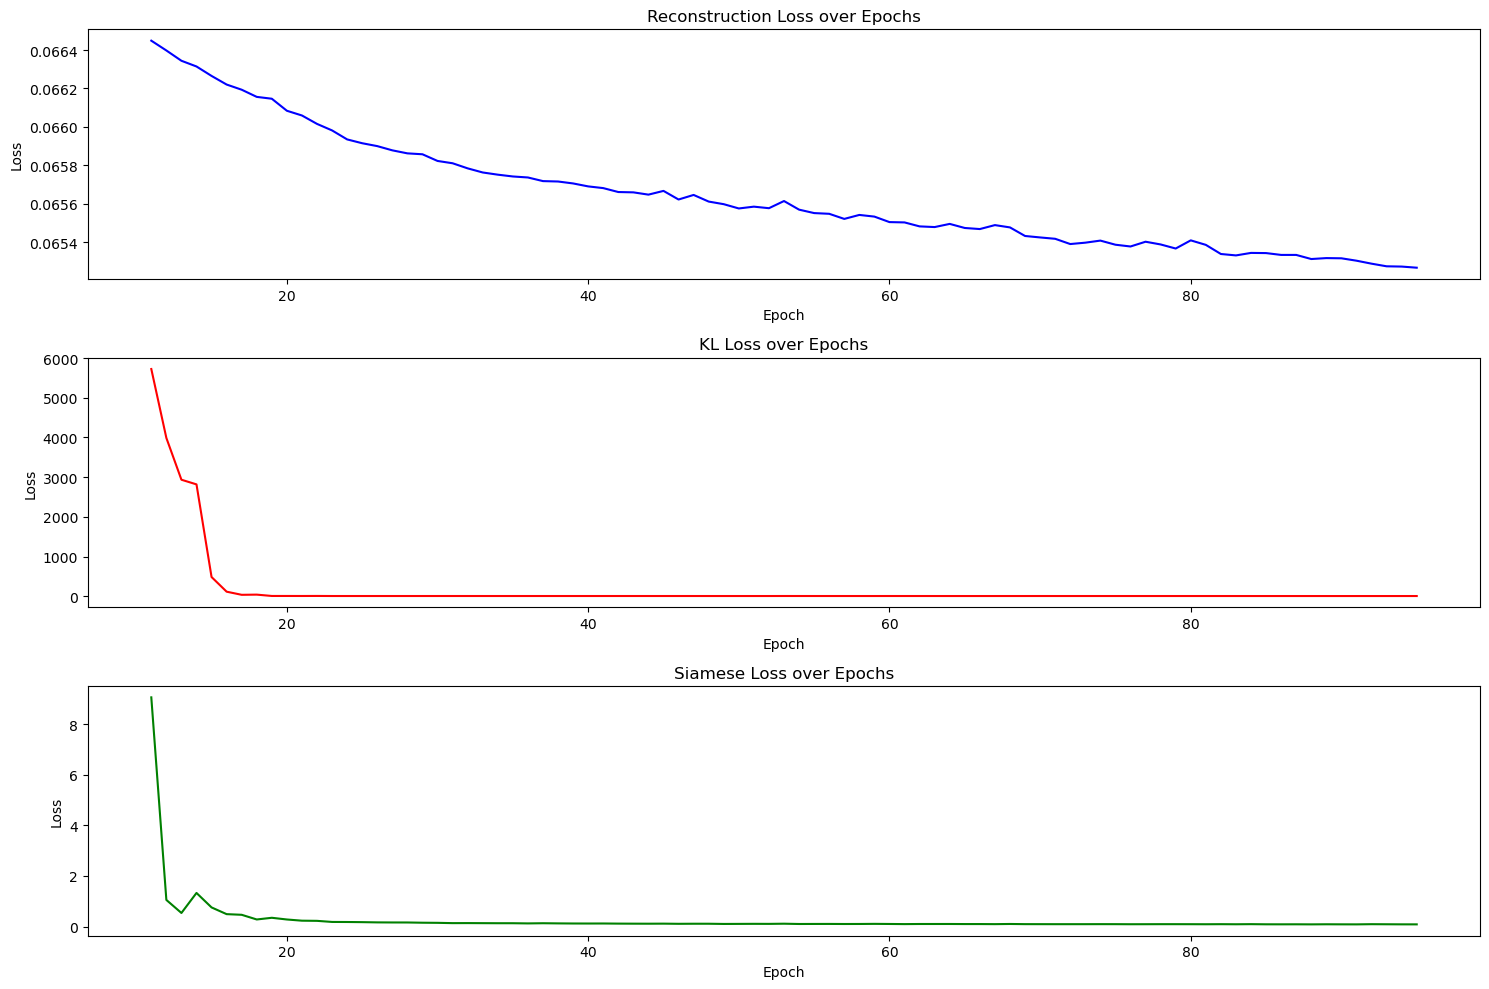

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generating random data for each loss type
epochs = np.arange(11, 96)

# Creating a figure with 3 subplots
plt.figure(figsize=(15, 10))

# Plot for Reconstruction Loss
plt.subplot(3, 1, 1)
sns.lineplot(x=epochs, y=recon_losses[10:95], color='blue')
plt.title('Reconstruction Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for KL Loss
plt.subplot(3, 1, 2)
sns.lineplot(x=epochs, y=kl_losses[10:95], color='red')
plt.title('KL Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Siamese Loss
plt.subplot(3, 1, 3)
sns.lineplot(x=epochs, y=siamese_losses[10:95], color='green')
plt.title('Siamese Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()

plt.savefig('losses_curve.pdf', format='pdf')
plt.show()

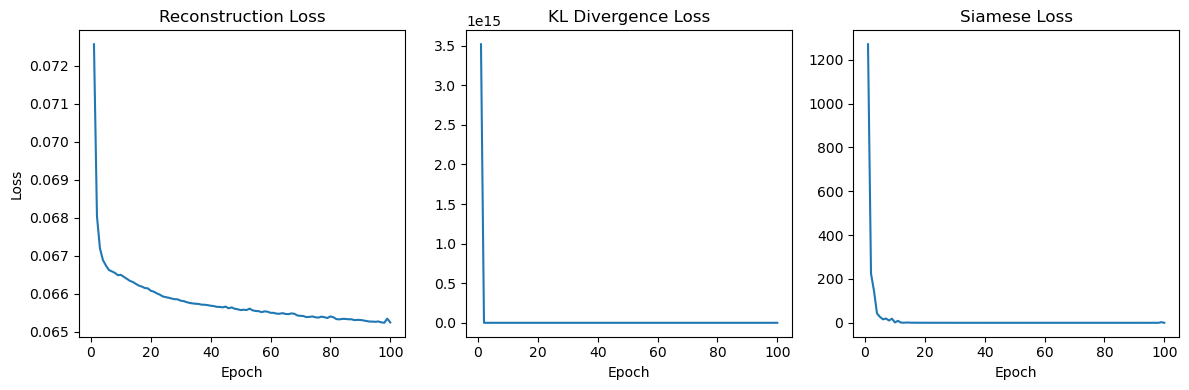

In [ ]:
from matplotlib import pyplot as plt

# Plotting the losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, recon_losses, label='Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs, kl_losses, label='KL Divergence Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')

plt.subplot(1, 3, 3)
plt.plot(epochs, siamese_losses, label='Siamese Loss')
plt.title('Siamese Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

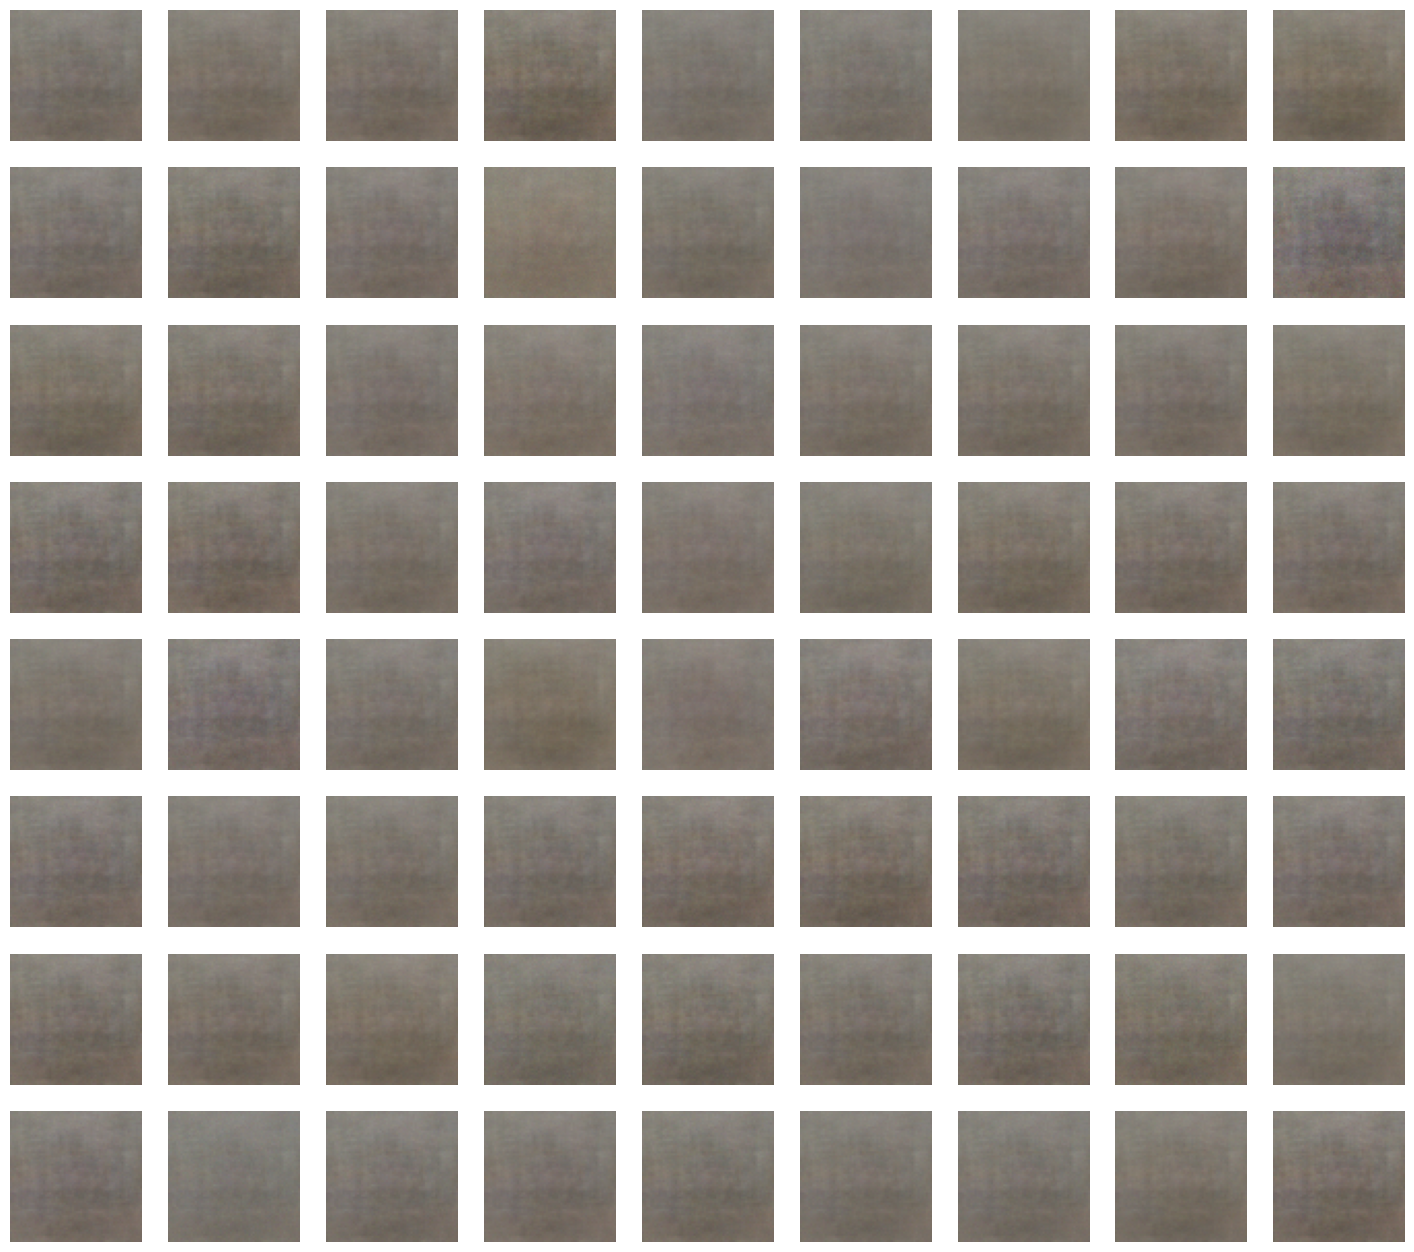

In [ ]:
import matplotlib.pyplot as plt

siavae = siavae.to(device)

# Select the first 10 EEG scans
eeg_samples = ffts50_raw_test[0:72]

# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _, _ = siavae(eeg_samples.to(device))

# Convert the reconstructed images to NumPy for visualization
reconstructed_images = reconstructed_images.detach().cpu().numpy()

# Reshape and scale the images as needed for visualization
reconstructed_images = reconstructed_images.reshape(-1, 64, 64, 3)

# Number of rows and columns
n_cols = 9
n_rows = eeg_samples.shape[0] // n_cols

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))  # Adjust figsize if needed
for i, ax in enumerate(axes.flatten()):
    if i < len(reconstructed_images):
        ax.imshow(reconstructed_images[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for any unused subplots

plt.show()

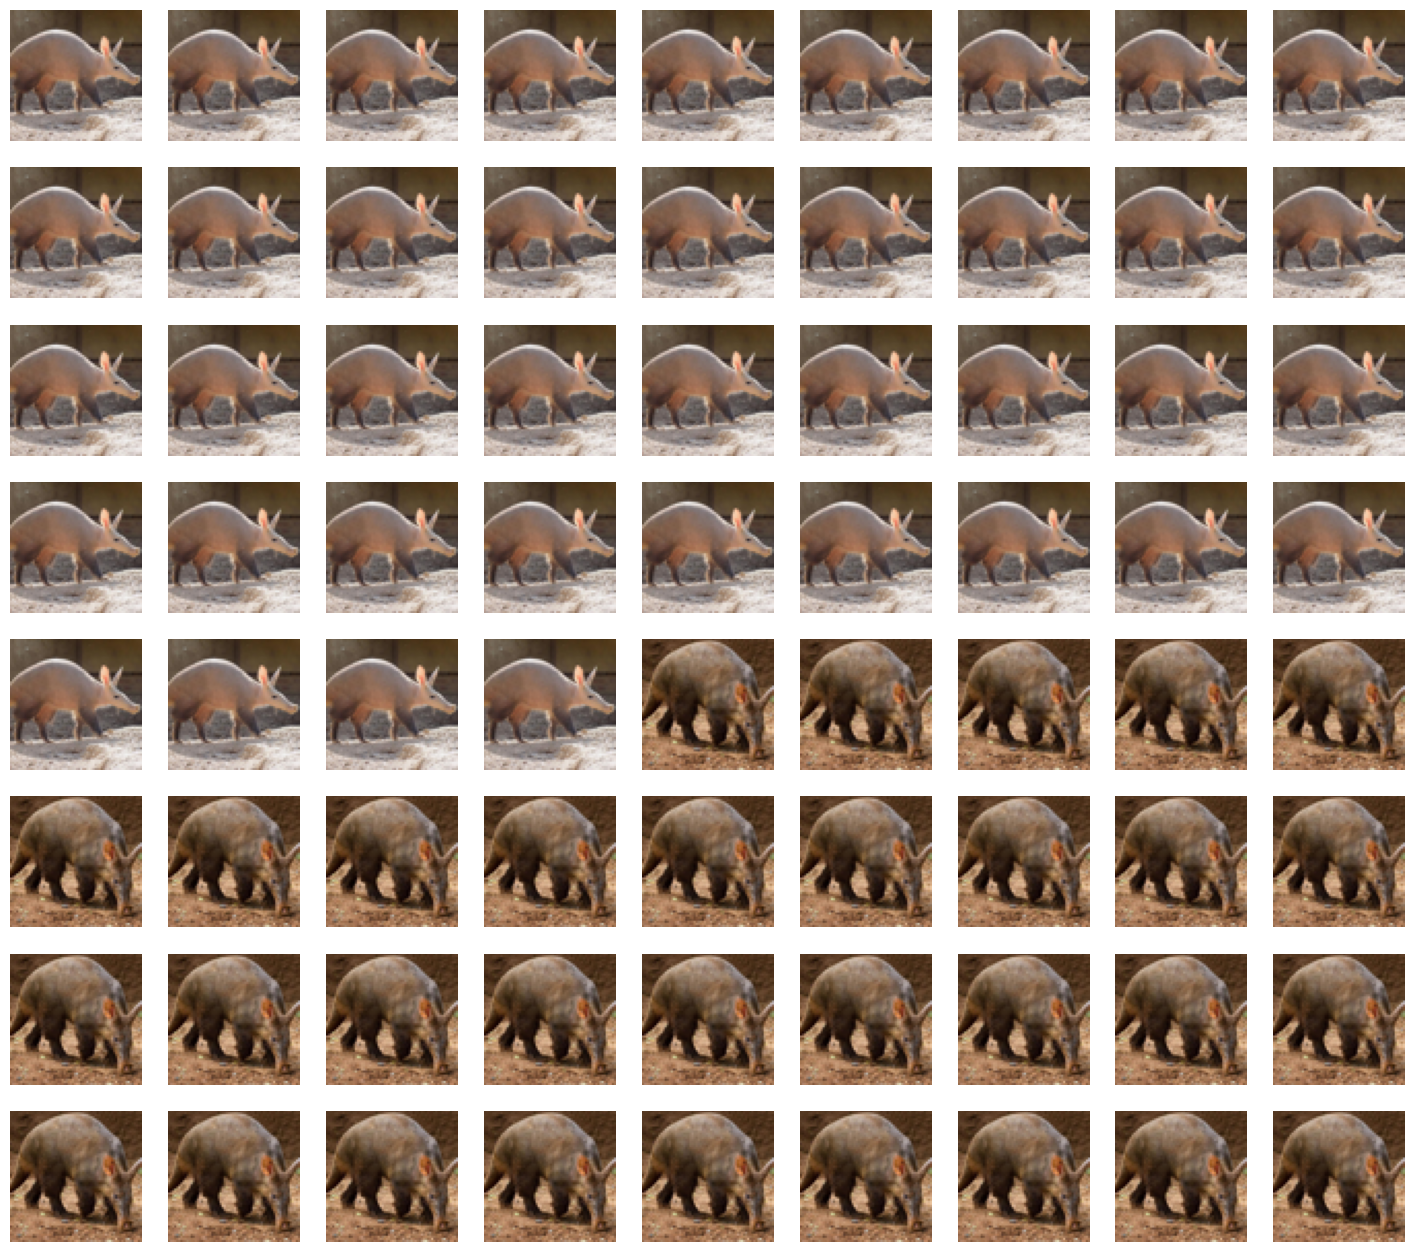

In [ ]:
import matplotlib.pyplot as plt

real_images = images50_train[0:72]

# Convert the reconstructed images to NumPy for visualization
real_images = real_images.detach().cpu().numpy()

# Reshape and scale the images as needed for visualization
real_images = real_images.reshape(-1, 64, 64, 3)

# Number of rows and columns
n_cols = 9
n_rows = real_images.shape[0] // n_cols

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))  # Adjust figsize if needed
for i, ax in enumerate(axes.flatten()):
    if i < len(real_images):
        ax.imshow(real_images[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for any unused subplots

plt.show()

# Classifier on Latents

In [ ]:
model = siavae.to(device)

In [ ]:
recon_image, z, mu, log_var = model(ffts50_raw_train.to(device))

classifier_inputs_tensor = z.detach()
classifier_outputs_tensor = onehot50_train.detach()

classifier_inputs_np = classifier_inputs_tensor.cpu().numpy()
classifier_outputs_np = classifier_outputs_tensor.cpu().numpy()

print(classifier_inputs_np.shape)
print(classifier_outputs_np.shape)

(36000, 25)
(36000, 100)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Assuming your latent vector size and number of classes
input_size = 25
hidden_size = 128  # You can experiment with this
num_classes = 100  # As you have 50 image classes
classifier_model = MultiClassClassifier(input_size, hidden_size, num_classes)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

cvae_class_dataset = TensorDataset(classifier_inputs_tensor, classifier_outputs_tensor)

cvae_class_data_loader = DataLoader(cvae_class_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)


num_epochs = 200
epoch_losses = []

for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(cvae_class_data_loader, leave=True)

    for inputs, targets in loop:
        # Forward pass
        outputs = classifier_model(inputs.to('cpu'))
        loss = criterion(outputs, targets.argmax(dim=1))  # Convert one-hot to class indices

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

    # Close the tqdm loop after the epoch ends
    loop.close()

Epoch [200/200]: 100%|██████████| 1125/1125 [00:02<00:00, 485.60it/s, loss=1.96]


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np

test_dataset = TensorDataset(ffts50_raw_test, onehot50_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

def test_model(latent_model, classifier_model, test_loader):
    latent_model.eval()
    classifier_model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            _, _, latents, _ = latent_model(inputs.to('cpu'))
            outputs = classifier_model(latents.to('cpu'))
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate accuracy
    predicted = np.argmax(all_outputs, axis=1)
    correct = np.sum(predicted == np.argmax(all_targets, axis=1))
    total = all_targets.shape[0]
    accuracy = 100.0 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Calculate AUROC for each class
    counter = 0

    auroc_per_class = []
    for i in range(all_targets.shape[1]):
        try:
            score = roc_auc_score(all_targets[:, i], all_outputs[:, i])
            auroc_per_class.append(score)
        except ValueError:
            counter += 1
            pass  # This occurs if a class is not represented in the targets

    # Calculate average AUROC
    avg_auroc = np.mean(auroc_per_class)
    print(f'Number of classes not included in AUROC calculation: {counter}')
    print(f'Average AUROC: {avg_auroc:.2f}')

# Example Usage
# Assuming you have a DataLoader 'test_loader' for your test dataset
# and your models 'latent_model' and 'classifier_model'
test_model(model.cpu(), classifier_model, test_loader)

Accuracy of the model on the test dataset: 19.57%
Number of classes not included in AUROC calculation: 0
Average AUROC: 0.97


In [ ]:
_, _, latents, _ = model(ffts50_raw_test)
outputs = classifier_model(latents.to('cpu'))

prediction = np.argmax(outputs.detach().numpy(), axis=1)

print(prediction[0:40])

[99 93 98 98 99 93 93 93 99 99 93 92 99 99 93 98 93 93 99 99 99 99 93 99
 98 98 98 93 93 93 98 93 99 93 93 98 93 90 98 92]


In [ ]:
# torch.save(model.state_dict(), 'models/siavae_97percent_auroc_19.57percent_accuracy.pth')
# torch.save(classifier_model.state_dict(), 'models/classifier_siavae_97percent_auroc_19.57percent_accuracy.pth')

# Never Before Seen Classes

In [ ]:
eegs_new = eeg_dataset_np[773 : 774]
eegs_new_tensor = torch.tensor(eegs_new).float()

eegs_new_tensor = eegs_new_tensor.permute(1, 2, 0, 3, 4)
eegs_new_tensor = eegs_new_tensor.reshape(-1, 17, 100)

ffts_new_tensor = torch.fft.rfft(eegs_new_tensor, dim=2)
ffts_new_tensor = torch.abs(ffts_new_tensor)

ffts_new_tensor = ffts_new_tensor.flatten(start_dim=1)

print(ffts_new_tensor.shape)

torch.Size([40, 867])


In [ ]:
_, _, new_latents, _ = model(ffts_new_tensor)
new_outputs = classifier_model(new_latents.to('cpu'))

new_prediction = np.argmax(new_outputs.detach().numpy(), axis=1)

print(new_prediction)

[ 0  9  8  9 11 19 12 19 23 23 20 28 35 38 31 38 40 49 40 49 51 53 56 53
 65 63 61 63 70 73 70 78 85 84 84 84 91 98 91 98]


In [ ]:
frequency_dict = {value: np.sum(new_prediction == value) for value in np.unique(new_prediction)}

frequency_dict

{0: 1,
 8: 1,
 9: 2,
 11: 1,
 12: 1,
 19: 2,
 20: 1,
 23: 2,
 28: 1,
 31: 1,
 35: 1,
 38: 2,
 40: 2,
 49: 2,
 51: 1,
 53: 2,
 56: 1,
 61: 1,
 63: 2,
 65: 1,
 70: 2,
 73: 1,
 78: 1,
 84: 3,
 85: 1,
 91: 2,
 98: 2}